### Module 5G - Solar Farm Manufacturing

Written for AIFS.   
Copyright 2023 Tarek Zohdi, Emre Mengi, Omar Betancourt, Payton Goodrich. All rights reserved.

In this project, you will use machine learning / a genetic algorithm to find optimal design parameters for a solar farm.

In [6]:
################################## Importing Packages ####################################################

import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
from matplotlib import animation
from matplotlib import rc
plt.rcParams.update({'font.size': 18})
from scipy.stats import uniform
import pandas as pd
from IPython.display import display, HTML
import Zohdi_Utils as zu

### **Problem 1:** Theory-Based Exercises ###

Answer the following questions *prior* to coding the assignment to better understand the background physics and mathematics that govern the given models. You **may** solve these problems by hand **and/or** using computational tools such as *Python* etc. Please include all handwritten work and code used to solve each problem.

**Problem 1.1:** For a parametrized test surface given by 

\begin{equation}
        x_{3}=2+A\left(\sin \frac{2 \omega_{1} \pi x_{1}}{L_{1}}\right) \sin \left(\frac{2 \omega_{2} \pi x_{2}}{L_{2}}\right)
\end{equation}
    
Analytically solve for the gradient of the surface.

**ANSWER:** Components of the gradient can be computed as:

\begin{equation}
    \nabla F=\frac{\partial F}{\partial x_1} \boldsymbol{e}_1+\frac{\partial F}{\partial x_2} \boldsymbol{e}_2+\frac{\partial F}{\partial x_3} \boldsymbol{e}_3
\end{equation}


$G\left(x_1, x_2\right)$ in parametric can be computed by:

\begin{equation}
    F\left(x_1, x_2, x_3\right)=G\left(x_1, x_2\right)-x_3=0
\end{equation}

The gradient can be rewritten as:

\begin{equation}
    \nabla F=\frac{\partial G}{\partial x_1} \boldsymbol{e}_1+\frac{\partial G}{\partial x_2} \boldsymbol{e}_2-\boldsymbol{e}_3
\end{equation}

For the parametrized test surface given:

\begin{equation}
    \begin{gathered}
x_3=2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \\
\nabla F=\frac{\partial\left(2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right)\right)}{\partial x_1} \boldsymbol{e}_1+\frac{\partial\left(2+A \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right)\right)}{\partial x_2} \boldsymbol{e}_2-\boldsymbol{e}_3 \\
=\left(\frac{2 A \omega_1 \pi}{L_1}\right) \cos \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \sin \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \boldsymbol{e}_1+\left(\frac{2 A \omega_2 \pi}{L_2}\right) \sin \left(\frac{2 \omega_1 \pi x_1}{L_1}\right) \cos \left(\frac{2 \omega_2 \pi x_2}{L_2}\right) \boldsymbol{e}_2-\boldsymbol{e}_3
\end{gathered}
\end{equation}

**Problem 1.2:** Write down the Forward Euler equation for time discretization. Explain all the terms.

**ANSWER**: The forward Euler discretization for position and velocity terms are as follows:

\begin{equation}
 \bm{r}_i(t +\Delta t) \; \dot{=} \; \bm{r}_i(t) +  \bm{v}_i(t)\Delta t
\end{equation}

Since the speed of light is constant, the only PDE we are solving is to update our ray position.

### **Problem 2:** Coding Exercises ###  
Use the given python notebook template to complete the following coding exercises.

**Problem 2.1:** Define the constants used in the simulation. Use the variable glossary at the end of the assignment.

In [7]:
# ################################## Problem 2.1 ####################################################

## System Parameters
Ptot = 1000 #FILL IN HERE # Total power per unit area (W/m^2) 
Nr = 1000 #FILL IN HERE # Number of light rays
sReg = 0.5 #FILL IN HERE # domain size of solar rays (m)
hReg = 4 #FILL IN HERE # initial height of solar rays (m)
Pmin = 0.1 #FILL IN HERE #fraction of total power at which we stop tracking a ray

# cutoff ratios for ground absorption
Gm = 0.4 #FILL IN HERE
Gp = 0.8 #FILL IN HERE

domLim = 2.5 #FILL IN HERE # Limit of domain in e1 and e2 domain (m)
c = 3E8 #FILL IN HERE # Speed of light in a vacuum (m/s)
thetaR = 0 #FILL IN HERE # Incoming angle of light (radians)

## Genetic Algorithm Parameters
K = 6 #FILL IN HERE # Strings generated by breeding
P = 6 #FILL IN HERE # Surviving strings for breeding
S = 20 #FILL IN HERE # Design strings per generation
G = 100 #FILL IN HERE # Total Generations
numLam = 12 #FILL IN HERE # Number of parameters per design string
w1 = 1 #FILL IN HERE # Cost function weight
w2 = 0.5 #FILL IN HERE # Cost function weight

# Search Bounds
theta1SB = [-np.pi/2, np.pi/2] #FILL IN HERE # Solar Panel rotation about the e1-axis (radians)
theta2SB = [-np.pi/2, np.pi/2] #FILL IN HERE # Solar Panel rotation about the e2-axis (radians)
theta3SB = [-np.pi/2, np.pi/2] #FILL IN HERE # Solar Panel rotation about the e3-axis (radians)
ngSB = [1,100] #FILL IN HERE # Refractive index of ground
nsSB = [1,100] #FILL IN HERE # Refractive index of solar panel
R1SB = [0.05, 0.1] #FILL IN HERE # Solar Panel size parameter w.r.t. the e1-axis
R2SB = [0.125, 1.125] #FILL IN HERE # Solar Panel size parameter w.r.t. the e2-axis
R3SB = [0.125, 1.125] #FILL IN HERE # Solar Panel size parameter w.r.t. the e3-axis
p1SB = [1, 20] #FILL IN HERE # Solar Panel exponent w.r.t. the e1-axis
p2SB = [1, 20] #FILL IN HERE # Solar Panel exponent w.r.t. the e2-axis
p3SB = [1, 20] #FILL IN HERE # Solar Panel exponent w.r.t. the e3-axis
h0SB = [2, 2.5] #FILL IN HERE # Solar Panel height (m)

# max panel size parameters
R1max = R1SB[1]
R2max = R2SB[1]
R3max = R3SB[1]

# min panel exponent parameters
p1min = p1SB[0]
p2min = p2SB[0]
p3min = p3SB[0]

# ##################################################################################################################

**Problem 2.2:** Run the genetic algorithm.

In [8]:
################################# Call GA to optimize solar farm system #######################################################

Lam, Pi, Min, PAve, Ave, alphaMin, gammaMin, alphaPAve, gammaPAve, alphaAve, gammaAve = \
    zu.myGA(S,G,P,K,theta1SB, theta2SB, theta3SB, ngSB, nsSB, p1SB, p2SB, p3SB, R1SB, R2SB, R3SB, h0SB, 
         Nr,    c, sReg, hReg, numLam, w1, w2, domLim, Ptot, Gm, Gp, Pmin, thetaR,R1max,R2max,R3max,p1min,p2min,p3min)

/Users/emremengi/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


0.6196326856498474
0.6196326856498474
0.6196326856498474
0.6196326856498474
0.6196326856498474
0.6109583267560663
0.6031903324973793
0.6016387005891575
0.6016387005891575
0.5976017439110409
0.5931306320887872
0.5931306320887872
0.5931306320887872
0.5091305840693265
0.505232200820126
0.5029246911300551
0.5029246911300551
0.4977867323550254
0.4915105412773807
0.4915105412773807
0.4915105412773807
0.4915105412773807
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.4848493311525799
0.48484933115

### **Problem 3:** Analyzing Your Results ###  
Answer the following questions about the code you created.

**Problem 3.1:** Report your best-performing 4 designs in a table similar to the following, but replacing $\Lambda_i$ with the design variables specific to this project. Use *pandas DataFrame* to generate the table in cell *Problem 3.1*  

<img src="GAtable.png" width="400" />

In [9]:
################################# Problem 3.1 #######################################################

# Create the requested table using pandas data frame
GAoutputTable = {
    'Design': ['1', '2','3','4'],
    #FILL IN THE REST OF THE COLUMNS HERE
    'theta1' : Lam[0:4,0],
    'theta2' : Lam[0:4,1],
    'theta3' : Lam[0:4,2],
    'ng' : Lam[0:4,3],
    'ns' : Lam[0:4,4],
    'R1' : Lam[0:4,5],
    'R2' : Lam[0:4,6],
    'R3' : Lam[0:4,7],
    'p1' : Lam[0:4,8],
    'p2' : Lam[0:4,9],
    'p3' : Lam[0:4,10],
    'h0' : Lam[0:4,11],
    'Pi' : Pi[0:4]
}

df = pd.DataFrame(GAoutputTable)

display(HTML(df.to_html(index=False)))

**Problem 3.2/3.3:** Provide a convergence plot showing the total cost of the best design, the mean of all parent designs, and the mean of the overall population for each generation. Provide a plot showing the individual performance components (i.e., plot $\alpha$, $\gamma$, and $\Pi_{total}$), for the overall best performer. Do so by running cell *Problem 3.2/3.3*. Discuss any important observations such as how the parameters progress over the generations and what trade-offs your algorithm has to consider.

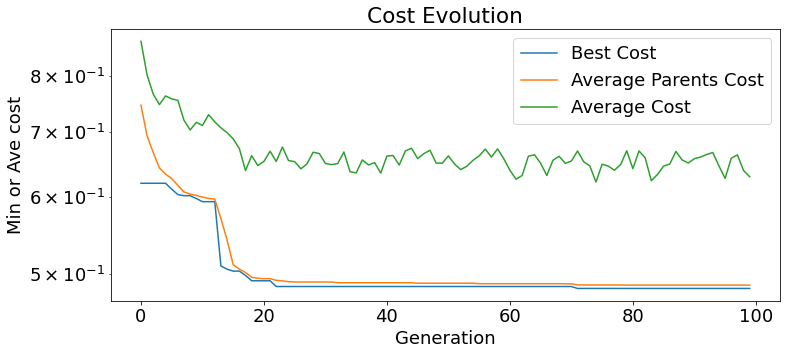

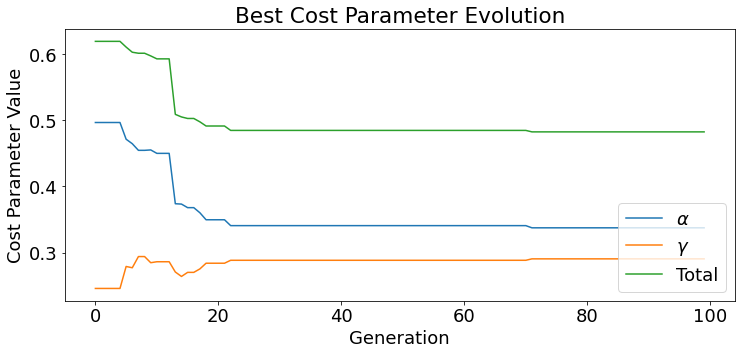

In [10]:
################################# Problem 3.2/3.3 #######################################################

zu.PlotSolarGAStatistics(G, Min, PAve, Ave, alphaMin, gammaMin)

**ANSWER:**

Findings:
  
Best cost is monotonously decreasing

Individual cost components might increase or decrease by the end, but the total cost is still decreasing

GA effectively finds the best solution around G=20


*(Accept answers that are in line with the specific plots generated per student basis)*

**Problem 3.4:** Include a series of plots showing how your best design captures the solar rays. Include 5 approximately evenly-spaced frames from $t = 0$ until the final time for your system. The solar panel and all light rays should be clearly shown with distinct marker styles, axes should be labeled. 

You can visualize the best solar farm behavior by running the animation below.

/Users/emremengi/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


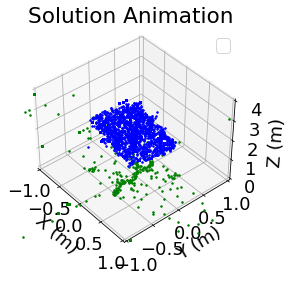

In [11]:
################################# Plotting Best Solution Animation ###############################################################

zu.PlotSolarAnimation(Lam[:,0], Nr, c, w1, w2, domLim, Ptot, Gm, Gp, Pmin, thetaR,R1max,R2max,R3max,p1min,p2min,\
            p3min,sReg,hReg)

Use the following variable glossary to fill in the required variables.

<img src="VariableGlossary.png" width="800" />